In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import optuna

In [15]:
df = pd.read_csv('aug_train.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [16]:
df.select_dtypes('object').nunique()

ordinal_cols = ['city', 'experience']
onehot_cols = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'company_size', 'company_type', 'last_new_job']
num_cols = ['enrollee_id', 'city_development_index', 'training_hours']
df.dtypes


enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [17]:
df.isnull().any()

enrollee_id               False
city                      False
city_development_index    False
gender                     True
relevent_experience       False
enrolled_university        True
education_level            True
major_discipline           True
experience                 True
company_size               True
company_type               True
last_new_job               True
training_hours            False
target                    False
dtype: bool

# EDA

In [18]:
df.select_dtypes('object').nunique()

city                   123
gender                   3
relevent_experience      2
enrolled_university      3
education_level          5
major_discipline         6
experience              22
company_size             8
company_type             6
last_new_job             6
dtype: int64

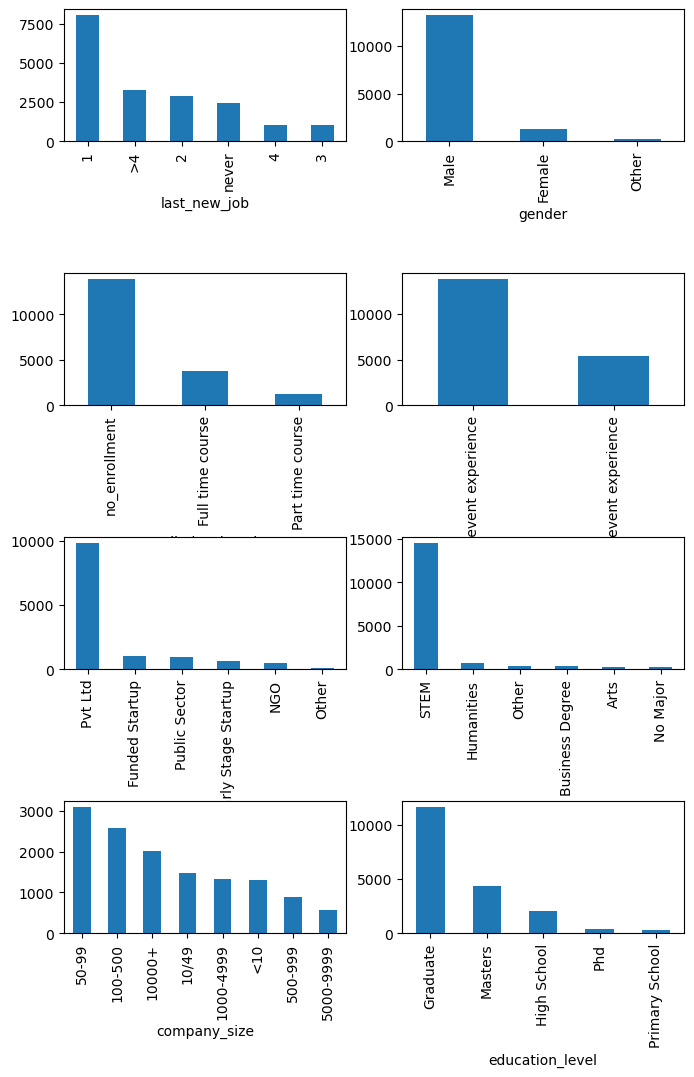

In [19]:
import math
# df.loc[:, df.columns not in ['city', 'experience']]
plot_cols = list(set(df.select_dtypes('object').columns).difference(set(['city', 'experience'])))

num_col = 2
num_row = math.ceil(len(plot_cols)/num_col)

fig, axes = plt.subplots(num_row, num_col, figsize = (8,12))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(plot_cols):
    df[col].value_counts().plot(kind='bar', ax=axes[(i//num_col)][i%num_col])

# Training

In [20]:
X = df.drop('target', axis=1)
y = pd.DataFrame(df['target'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
sample_row = X.iloc[0,:].to_dict()

In [21]:

num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

onehot_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessing = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('ordinal_pipeline', ordinal_pipeline, ordinal_cols),
    ('onehot_pipeline', onehot_pipeline, onehot_cols)
])

model = XGBClassifier()

pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('model', model)
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)


print(f'accuracy: {accuracy_score(y_valid, preds)}')


accuracy: 0.7670494084899095


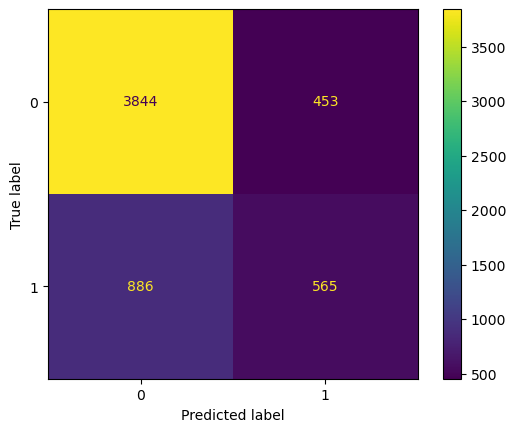

In [22]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

# Optuna

In [23]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 400)
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    clf = XGBClassifier(n_estimators=n_estimators, booster=booster)
    pipeline = Pipeline(steps=[
        ('transformer', preprocessing),
        ('model', clf)
    ])
    pipeline.fit(X_train, y_train)
    return pipeline.score(X_valid, y_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

model_params_list = ['n_estimators', 'booster']
model_params = dict()
for key, value in study.best_trial.params.items():
    if key in model_params_list:
        model_params[key] = value

clf = XGBClassifier(**model_params)
pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('model', clf)
])
pipeline.fit(X_train, y_train)



[I 2024-10-11 13:55:56,830] A new study created in memory with name: no-name-8a91c074-9ac9-4ff3-bb61-86000ec74ebc
[I 2024-10-11 13:55:57,228] Trial 0 finished with value: 0.7658315935977731 and parameters: {'n_estimators': 60, 'booster': 'gblinear'}. Best is trial 0 with value: 0.7658315935977731.
[I 2024-10-11 13:55:57,585] Trial 1 finished with value: 0.7654836464857342 and parameters: {'n_estimators': 151, 'booster': 'gbtree'}. Best is trial 0 with value: 0.7658315935977731.
[I 2024-10-11 13:55:57,945] Trial 2 finished with value: 0.7667014613778705 and parameters: {'n_estimators': 143, 'booster': 'gbtree'}. Best is trial 2 with value: 0.7667014613778705.


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['enrollee_id',
                                                   'city_development_index',
                                                   'training_hours']),
                                                 ('ordinal_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  un...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=143, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [24]:
import pickle
with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [25]:
from pydantic import BaseModel, ValidationError

class Job(BaseModel):
    enrollee_id: int
    city: object
    city_development_index: object
    gender: object
    relevent_experience: object
    enrolled_university: object
    education_level: object
    major_discipline: object
    experience: object
    company_size: object
    company_type: object
    last_new_job: object
    training_hours: object

with open('pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

print(sample_row)
job = Job(**sample_row)
inputs = pd.DataFrame([job.model_dump()])
pred = loaded_pipeline.predict(inputs)[0]
pred

{'enrollee_id': 8949, 'city': 'city_103', 'city_development_index': 0.92, 'gender': 'Male', 'relevent_experience': 'Has relevent experience', 'enrolled_university': 'no_enrollment', 'education_level': 'Graduate', 'major_discipline': 'STEM', 'experience': '>20', 'company_size': nan, 'company_type': nan, 'last_new_job': '1', 'training_hours': 36}


1

In [26]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        job = Job(**request.json)
        inputs = pd.DataFrame([job.model_dump()])
        pred = loaded_pipeline.predict(inputs)[0]
        response = {
            'prediction': int(pred)
        }
        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400

if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Oct/2024 13:56:06] "POST /predict HTTP/1.1" 200 -
